In [1]:
using Plots; gr()
using LaTeXStrings
# Set up plotting parameters
default(size=(700, 350), fc=:white)

In [2]:
function normalize(z)
    return z ./ abs.(z)
end

normalize (generic function with 1 method)

In [3]:
𝑓ₛ = 30720000

# Start near the first PUCCH transmission
t₀ = 0.0217
T = 2e-3

x = open("data/LTE_uplink_847MHz_2022-01-30_30720ksps.sigmf-data") do file
  skip(file,convert(Int, t₀ * 𝑓ₛ * 4))
  read!(file, Array{Int16}(undef,53102592));
end
@show length(x), x[1:5];

# Scale amplitude so that the PUCCH symbols have roughly the correct amplitude
x = (x[1:2:end] + 1im*x[2:2:end]) / 323200

# Correct for CFO. The CFO is measured with the PUSCH and DMRS.
Δf = -1060

x .*= exp.(1im * 2π * Δf / 𝑓ₛ * (1:length(x)));

(length(x), x[1:5]) = (53102592, Int16[-19, 442, -55, 386, -235])


In [4]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

160

In [5]:
# Poor man's Schmidl & Cox in Julia
cp_corr = similar(x, ComplexF64, 20 * Tu - cp_len - Tu)
for j in 1:length(cp_corr)
    # The - sign is to account for the fact that the 7.5 kHz frequency offset
    # of the uplink subcarrier performs a 180 deg rotation during Tu
    cp_corr[j] = -sum(x[j:j+cp_len-1] .* conj(x[j+Tu:j+Tu+cp_len-1]))
end

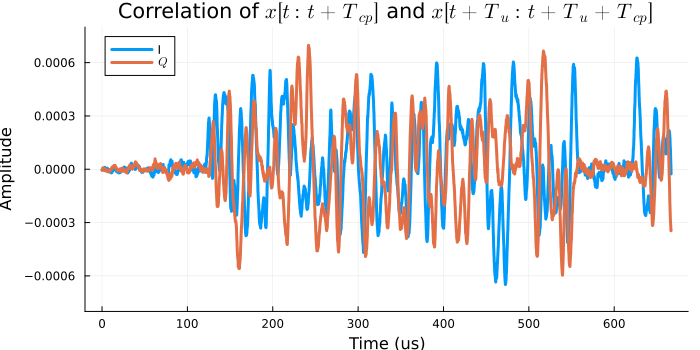

In [6]:
L = 10 * Tu
t = (1:L) / 𝑓ₛ * 1e6
plot(t, real(cp_corr[1:L])
    , label="I"
    , title = string("Correlation of ",L"x[t:t+T_{cp}]", " and ",L"x[t+T_u:t+T_u+T_{cp}]")
    , xlabel = "Time (us)", ylabel = "Amplitude"
    , legend =:topleft
    , linewidth = 3
    , ylims = (- .0008, .0008 )
)
plot!(t, imag(cp_corr[1:L])
    , label=L"Q"
    , linewidth = 3

)

In [7]:
a₀ = 3993

3993

In [8]:
slots = 1728  # according to total file length
nsymbols = slots * 7

# Timestamp for each slot. Timestamped to the beginning of
# the cyclic prefix of the first symbol of each slot.
t_slot = t₀ + (a₀ - cp_len2) / 𝑓ₛ .+ (0:slots-1) * 0.5e-3

# All possible RBs used by PUCCH
RBs = [724:735, 748:759, 1288:1299, 1312:1323]


4-element Vector{UnitRange{Int64}}:
 724:735
 748:759
 1288:1299
 1312:1323

In [9]:
using FFTW

In [10]:
# Here we take into account the 7.5 kHz shift of the uplink
# subcarriers
freq_syms = 7.5e3 .+ fftshift(fftfreq(Tu, 1/𝑓ₛ ))
freq_syms = [freq_syms[rb] for rb in RBs]


4-element Vector{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}:
 7499.999999995216:1.5894571940104167e-11:7499.999999995391
 7499.999999995597:1.5894571940104167e-11:7499.999999995772
 7500.00000000418:1.5894571940104167e-11:7500.000000004355
 7500.000000004562:1.5894571940104167e-11:7500.000000004737

In [11]:
# Extract symbols
symbols = zeros(Complex{Float32}, nsymbols, 12)
active_rb = zeros(Int, nsymbols)
for j in 1:nsymbols
    # For each slot, we need to advance cp_len2-cp_len because of the
    # longer cyclic prefix of the first symbol in each slot. delta counts
    # this.
    delta = (cp_len2 - cp_len) * div(j - 1, 7); # @show delta

    # @show size(x[3993:3993+(Tu-1)]), a0+j*(Tu+cp_len)+delta

    # Before performing the FFT, we multiply by an exponential to cancel out the 7.5 kHz shift of
    # the symbols. The phase of this exponential is zero at the start of the symbol.
    start = a₀+ (j-1) * (Tu+cp_len) +delta; # @show start, start + 1
    syms = fftshift(fft(x[start+1:start+1+(Tu-1)] .* exp.(-1.0im * π * collect(1:Tu) / Tu))); #@show size(syms)
    # @show syms[1:4]
    syms_rb = [syms[rb] for rb in RBs]; #@show typeof(syms_rb), typeof(syms)
    
    # Power detect the RB in which the transmission happens
    # rb = argmax(sum(abs2.(syms_rb[1]), dims=3), dims=1)[1]; @show rb
    rb = argmax(sum(abs2.(syms_rb[3]), dims=3), dims=1)[end]; @show syms_rb, rb
    active_rb[j] = rb
    
    # Extract only the subcarriers in that RB
    # symbols[j, :] = syms_rb[rb, :]
end

# Reshape the symbols array
# symbols = reshape(symbols, (slots, 7, 12))


(syms_rb, rb) = (Vector{ComplexF64}[[-0.003628998723501843 - 0.030730292791166944im, -0.015332424519569246 - 0.029301115707636136im, -0.00617273491872955 + 0.003625595070538257im, 0.015738554795019448 - 0.058642840308651245im, -0.05084186413147063 - 0.04992759978884416im, 0.009883138524854524 - 0.02313858948593322im, 0.003379490814120985 - 0.037632984500399896im, -0.0704097156936651 + 0.0497145736518102im, -0.0383061507727137 + 0.04506305491584815im, 0.026181971079492924 - 0.03810519657772627im, -0.05706756173253526 + 0.012781350727115257im, -0.041143301400999525 + 0.011773919666415385im], [-0.04046893368506421 - 0.019391429688748872im, 0.1979602252824516 + 1.0949767459358044im, 0.9540295918693111 + 0.3218252200716132im, 0.825651740459148 - 0.7520929872344299im, 1.0715071661071582 - 0.22177812596241864im, -1.0175251391215931 - 0.3036672540335186im, 0.7045397257803604 + 0.7837339695975147im, -0.2582122406549549 - 1.016471045176175im, 0.3219344843521029 - 0.9482609741980226im, 0.67409876

Excessive output truncated after 524602 bytes.


(syms_rb, rb) = (Vector{ComplexF64}[[0.06020476468770048 + 0.02981588143824955im, 0.021113202678073685 + 0.02415253379296938im, 0.01992720070183348 + 0.0018400659217360886im, 0.03956314708517983 + 0.02448465360217604im, -0.018761811906354946 - 0.023306833360543098im, -0.01825457211990424 - 0.014668647426576243im, -0.03665908201427228 - 0.006260734316746011im, -0.033281504047751286 - 0.028216410833590777im, 0.024648908936136325 - 0.034733798900324964im, -0.06145697049344684 + 0.02928607804838941im, -0.025824648504003143 + 0.038920162941454825im, 0.04194390484971805 + 0.04773901669136468im], [-0.03716743664433242 + 0.02174652368722068im, -0.006346757471189139 + 0.0010444840640561823im, 0.10854064409165942 - 0.029750026113510863im, 0.035599844820385376 - 0.06373108410421241im, 0.007343340261062311 - 0.02129860747771268im, 0.017955030745047718 - 0.0528165141246853im, 0.03568178798558917 + 0.07858231317994036im, 0.06363241458864917 - 0.05975258854658229im, 0.012161788942619434 + 0.01648384